# Given Catchment and Flowline delineate valley bottom

Cross Section BreakPoint -> mode of HAND:
1. slope threshold
2. linear fit
3. wavelet of profile curvature

V-BET (small, medium, large buffers + slope thresholds)
how to determine those thresholds? 
- geomorphons, linear function of accumulation x width and slope

how to handle meander messing with cross sections?
- geomorphons
- center line of 10m contour?

Create Validation Dataset

visualize with pygmt?

In [157]:
import rioxarray
import geopandas as gpd
import pandas as pd
import numpy as np
import xrspatial
from shapely import Point, LineString, Polygon
import matplotlib.pyplot as plt

In [141]:
def get_nearest_vertices(point, linestring):
    line_coords = linestring.coords
    distances = [point.distance(Point(x, y)) for x, y in line_coords]
    nearest_indices = np.argsort(distances)[:2]
    nearest_vertices = [Point(line_coords[int(i)]) for i in nearest_indices]
    return nearest_vertices

def sample_point_on_perpendicular_line(point, A, B, alpha):
    length = A.distance(B)
    x = point.x + alpha * (A.y - B.y) / length
    y = point.y + alpha * (B.x - A.x) / length
    return Point(x,y)

def get_cross_section(point, linestring, width, alpha_increment, raster):
    A,B = get_nearest_vertices(point, linestring)
    npoints = width // alpha_increment
    positive_alphas = [alpha_increment * n for n in range(npoints+1)]
    negative_alphas = [-i for i in positive_alphas]
    alphas = negative_alphas + positive_alphas
    sample_points = [sample_point_on_perpendicular_line(point, A, B, alpha) for alpha in alphas]
    values = [raster.sel(x=point.x, y=point.y, method='nearest').values.item() for point in sample_points]
    return (alphas,values,sample_points)

In [96]:
dem = rioxarray.open_rasterio("../toy_data/11_dem.tif").squeeze()
hand = rioxarray.open_rasterio("../toy_data/11_hand.tif").squeeze()
flowline = gpd.read_file("../toy_data/11_streamline.shp")
stream_raster = rioxarray.open_rasterio("../toy_data/11_stream.tif").squeeze()

hand = hand.where(hand != -32768, np.nan)
stream_raster = stream_raster.where(stream_raster != -32768, np.nan)

In [98]:
slope = xrspatial.slope(hand)
hs = xrspatial.hillshade(dem)

/Users/arthurkoehl/Library/Caches/pypoetry/virtualenvs/valleys-apqonAG6-py3.10/lib/python3.10/site-packages/xrspatial/hillshade.py:23: RuntimeWarning: invalid value encountered in sin
  shaded = np.sin(altituderad) * np.sin(slope) + \
/Users/arthurkoehl/Library/Caches/pypoetry/virtualenvs/valleys-apqonAG6-py3.10/lib/python3.10/site-packages/xrspatial/hillshade.py:24: RuntimeWarning: invalid value encountered in cos
  np.cos(altituderad) * np.cos(slope) * \
/Users/arthurkoehl/Library/Caches/pypoetry/virtualenvs/valleys-apqonAG6-py3.10/lib/python3.10/site-packages/xrspatial/hillshade.py:25: RuntimeWarning: invalid value encountered in cos
  np.cos((azimuthrad - np.pi/2.) - aspect)


In [6]:
points = [flowline.interpolate(i/20, normalized=True) for i in range(21)]
points = pd.concat(points, ignore_index=True)
points = gpd.GeoSeries(points)
points.head()

0    POINT (-198247.926 -102782.473)
1    POINT (-198235.250 -102810.136)
2    POINT (-198211.257 -102827.432)
3    POINT (-198182.922 -102816.378)
4    POINT (-198154.120 -102812.446)
dtype: geometry

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

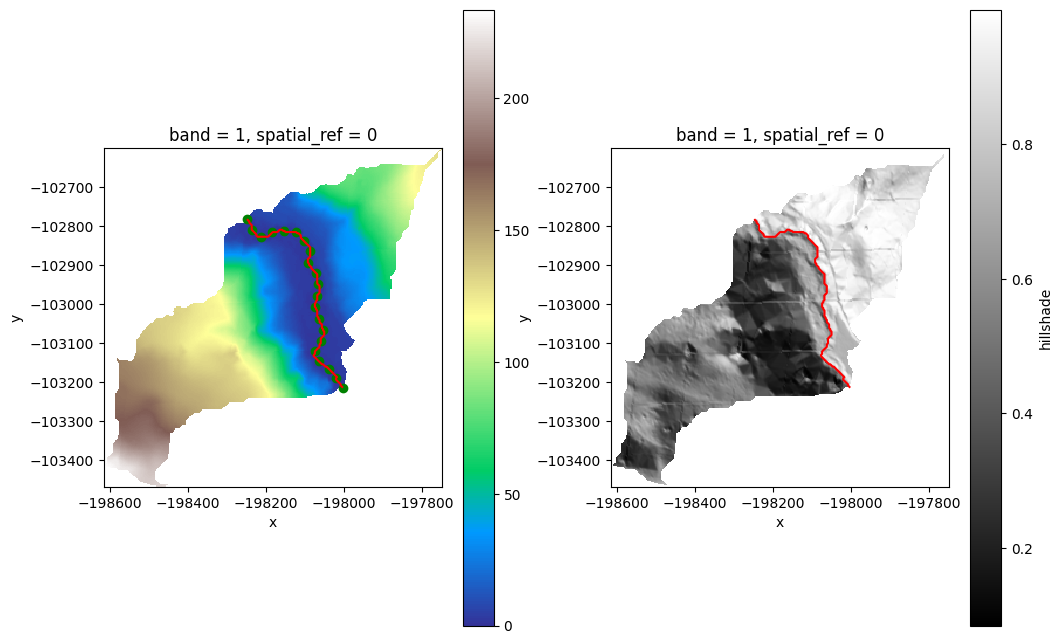

In [99]:
fig, axes = plt.subplots(1,2, figsize=(12,8))

hand.plot(ax=axes[0], cmap='terrain')
flowline.plot(ax=axes[0], color='red')
points.plot(ax=axes[0], color='green')

hs.plot(ax=axes[1], cmap='gray')
flowline.plot(ax=axes[1], color='red')

<Axes: >

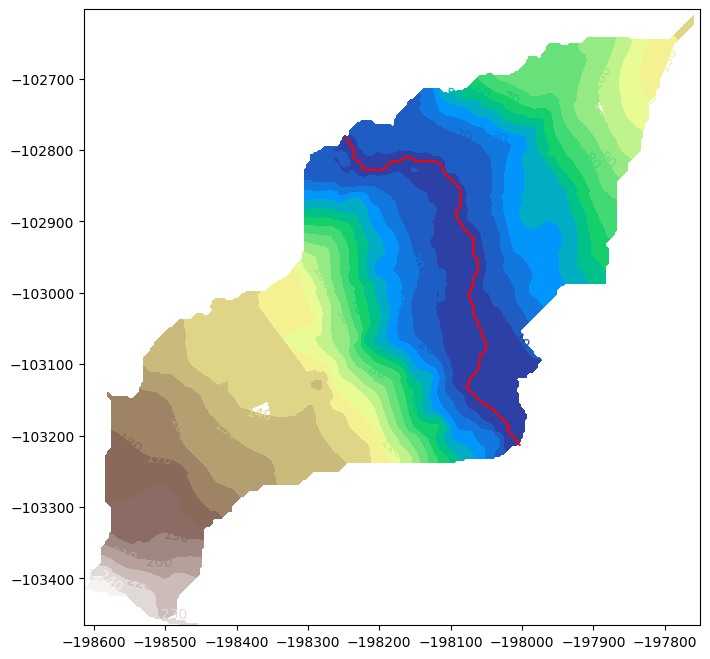

In [97]:
# contour plot
fig, ax = plt.subplots(figsize=(12,8))
bounds = dem.rio.bounds()
extent = (bounds[0], bounds[2], bounds[1], bounds[3])
cs = ax.contourf(dem, levels=25, extent=extent, origin='upper', cmap='terrain')
ax.clabel(cs, inline=True, fontsize=10)
flowline.plot(ax=ax, color='red')

In [142]:
dfs = []
for i,point in enumerate(points):
    res = {}
    alphas, elevations, sample_points = get_cross_section(point, flowline['geometry'][0], 500, 4, hand)
    _, slopes, _ = get_cross_section(point, flowline['geometry'][0], 500, 4, slope)
    res['alpha'] = alphas
    res['elevation'] = elevations
    res['slope'] = slopes
    res['point'] = sample_points
    res['cross_section_index'] = i
    df = pd.DataFrame(res)
    dfs.append(df)
points_df = pd.concat(dfs)
points_df

,alpha,elevation,slope,point,cross_section_index
0,0,0.000000,NaN,POINT (-198247.92595611996 -102782.47306384971),0
1,-4,1.299292,NaN,POINT (-198250.7543832447 -102785.30149097445),0
2,-8,2.099445,NaN,POINT (-198253.58281036944 -102788.1299180992),0
3,-12,NaN,NaN,POINT (-198256.4112374942 -102790.95834522395),0
4,-16,2.344062,NaN,POINT (-198259.23966461894 -102793.7867723487),0
...,...,...,...,...,...
247,484,NaN,NaN,POINT (-198344.3901841778 -103556.31842132506),20
248,488,NaN,NaN,POINT (-198347.21861130255 -103559.1468484498),20
249,492,NaN,NaN,POINT (-198350.04703842732 -103561.97527557454),20
250,496,NaN,NaN,POINT (-198352.87546555206 -103564.8037026993),20


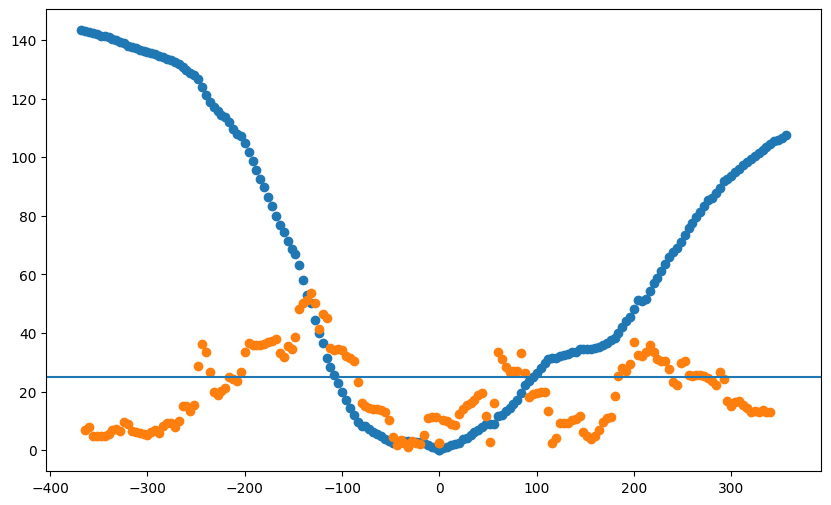

In [143]:
i = 12

fig, ax = plt.subplots(1,1, figsize=(10,6))
df = points_df.loc[points_df['cross_section_index'] == i]
df = df.loc[np.isfinite(df['elevation'])]
ax.scatter(df['alpha'], df['elevation'])
ax.scatter(df['alpha'], df['slope'])
ax.axhline(y=25)

In [80]:
df

,alpha,elevation,slope,point,cross_section_index
0,0,0.0,1.070686,POINT (-198086.07382785206 -102864.20793448285),7
1,-4,0.41498539794921996,9.67429,POINT (-198090.07382785206 -102864.20793448285),7
2,-8,1.6747417449951172,8.440332,POINT (-198094.07382785206 -102864.20793448285),7
3,-12,1.8755245208740234,4.447876,POINT (-198098.07382785206 -102864.20793448285),7
4,-16,2.017658233642578,1.3411554,POINT (-198102.07382785206 -102864.20793448285),7
...,...,...,...,...,...
302,204,73.45128342773438,14.478466,POINT (-197882.07382785206 -102864.20793448285),7
303,208,73.9386644091797,14.765244,POINT (-197878.07382785206 -102864.20793448285),7
304,212,75.56741807128907,20.243698,POINT (-197874.07382785206 -102864.20793448285),7
305,216,75.9400071826172,17.124454,POINT (-197870.07382785206 -102864.20793448285),7


In [144]:
# from points make a line
# plot that line and the sampled points on the dem
# get index of point on both sides where slope break is exceeded and plot that point in a different color
min_alpha_index = np.argmin(df['alpha'])
max_alpha_index = np.argmax(df['alpha'])
start = df['point'].iloc[min_alpha_index]
end = df['point'].iloc[max_alpha_index]

line = LineString([start, end])
line = gpd.GeoSeries(line)

<Axes: >

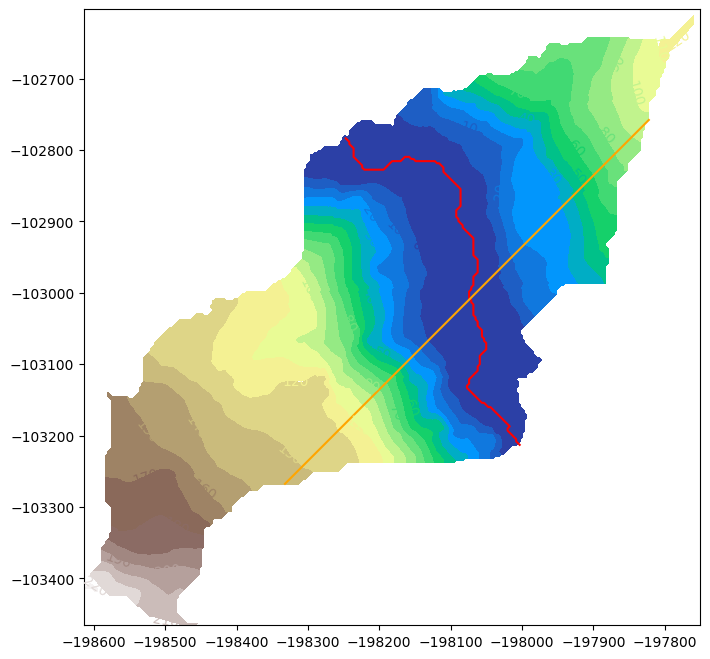

In [145]:
fig, ax = plt.subplots(figsize=(12,8))
bounds = hand.rio.bounds()
extent = (bounds[0], bounds[2], bounds[1], bounds[3])
cs = ax.contourf(hand, levels=25, extent=extent, origin='upper', cmap='terrain')
ax.clabel(cs, inline=True, fontsize=10)
flowline.plot(ax=ax, color='red')
line.plot(ax=ax, color='orange')

In [218]:
polygon = None
for level, collection in zip(cs.levels, cs.collections):
    if polygon:
        break
    for path in collection.get_paths():
        poly = Polygon(path.vertices)
        if poly.intersects(flowline.iloc[0]['geometry']):
            polygon = poly
            break


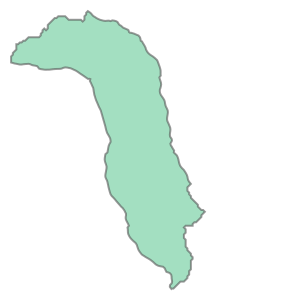

In [219]:
polygon

In [220]:
# need medial axis or skeleton but can only be one line? 